In [1]:
import torch
import utulek
import numpy as np

In [2]:
hps = {
    "batch_size": 128,
    "epochs": 64,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [3]:
class Cifar10Dataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.X, self.Y = utulek.fetch_tfds_img_ds("cifar10", split)
        self.X, self.Y = self.X.astype(np.float32), self.Y.astype(np.int64)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [4]:
dss = {
    "cifar10": (
        Cifar10Dataset("train"),
        Cifar10Dataset("test")
    )
}

In [5]:
dss["c10-dl"] = (
    torch.utils.data.DataLoader(dss["cifar10"][0], batch_size=hps["batch_size"]),
    torch.utils.data.DataLoader(dss["cifar10"][1], batch_size=hps["batch_size"])
)

for X, Y in dss["c10-dl"][0]:
    print(f"X \in {X.shape}")
    print(f"Y \in {Y.shape} of {Y.dtype}")
    break

X \in torch.Size([128, 32, 32, 3])
Y \in torch.Size([128]) of torch.int64


In [6]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(32**2*3, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 10)
        )

    def forward(self, X):
        X = self.flatten(X)
        logits = self.linear_relu_stack(X)
        return logits


print(model := NeuralNetwork().to(hps["device"]))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=10, bias=True)
  )
)


In [7]:
import time


loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
rs = {
    "to": 0,
    "step": 0,
    "test": 0
}


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for _, (X, Y) in enumerate(dataloader):
        tst = time.process_time()
        X, Y = X.to(hps["device"]), Y.to(hps["device"])
        rs["to"] += time.process_time() - tst

        tst = time.process_time()
        pred = model(X)
        loss = loss_fn(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rs["step"] += time.process_time() - tst


def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(hps["device"]), Y.to(hps["device"])
            pred = model(X)
            test_loss += loss_fn(pred, Y).item()
            correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"{epoch}: {(100*correct):>0.1f}% | {test_loss:>8f}")

In [8]:
%%time
for epoch in range(hps["epochs"]):
    train(dss["c10-dl"][0], model, loss_fn, optimizer)
    tst = time.process_time()
    test(dss["c10-dl"][1], model, loss_fn, epoch)
    rs["test"] += time.process_time() - tst

print(rs)

0: 10.7% | 2.290024
1: 11.8% | 2.278927
2: 14.7% | 2.268816
3: 17.2% | 2.258937
4: 19.2% | 2.249029
5: 20.5% | 2.238983
6: 21.7% | 2.228741
7: 22.8% | 2.218257
8: 23.5% | 2.207507
9: 24.2% | 2.196514
10: 24.7% | 2.185302
11: 25.3% | 2.173933
12: 25.7% | 2.162497
13: 26.2% | 2.151091
14: 26.6% | 2.139804
15: 26.8% | 2.128718
16: 27.0% | 2.117903
17: 27.3% | 2.107408
18: 27.7% | 2.097268
19: 28.0% | 2.087502
20: 28.2% | 2.078123
21: 28.6% | 2.069135
22: 28.8% | 2.060530
23: 29.3% | 2.052296
24: 29.5% | 2.044415
25: 29.6% | 2.036867
26: 29.7% | 2.029627
27: 29.8% | 2.022673
28: 30.0% | 2.015987
29: 30.1% | 2.009552
30: 30.4% | 2.003352
31: 30.5% | 1.997377
32: 30.8% | 1.991612
33: 30.8% | 1.986045
34: 31.0% | 1.980666
35: 31.1% | 1.975466
36: 31.1% | 1.970439
37: 31.4% | 1.965576
38: 31.4% | 1.960870
39: 31.6% | 1.956313
40: 31.8% | 1.951897
41: 31.9% | 1.947616
42: 32.1% | 1.943468
43: 32.2% | 1.939448
44: 32.3% | 1.935551
45: 32.4% | 1.931771
46: 32.5% | 1.928101
47: 32.8% | 1.924538
48

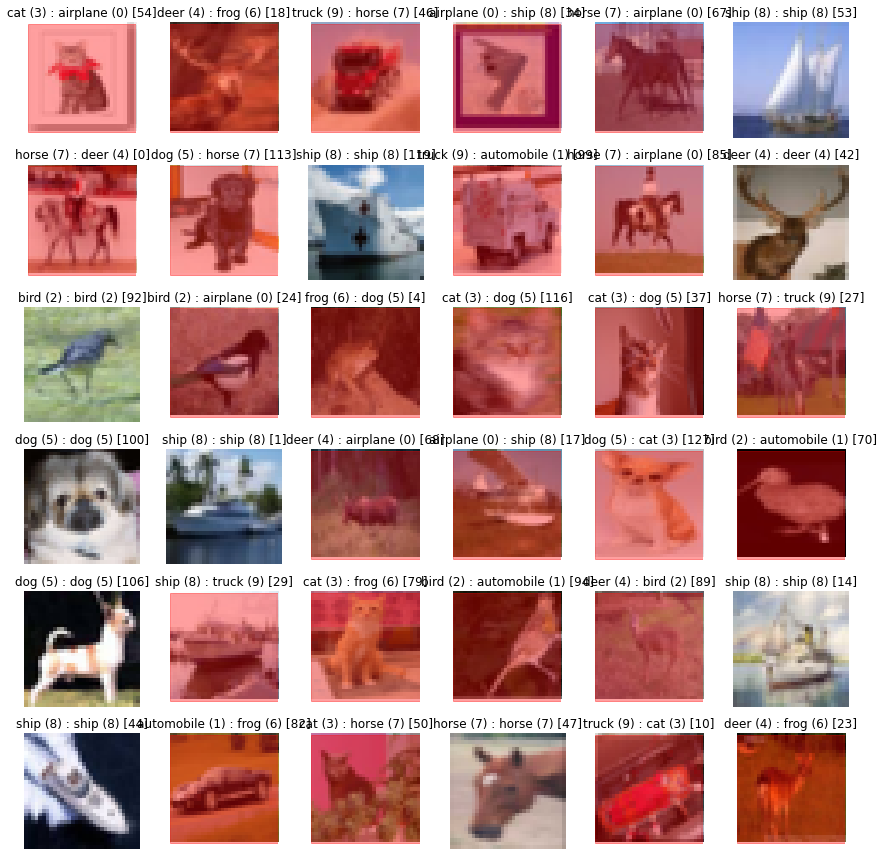

In [10]:
for X, Y in dss["c10-dl"][0]:
    pred = model(X.to(hps["device"])).argmax(axis=1).cpu()
    utulek.show_img_ds(X, Y, pred, labels=utulek.fetch_tfds_img_ds_labels("cifar10"), shape=(6, 6))
    break